# Naive Bayes

## Tools

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Dataset

In [3]:
data = pd.read_csv("combine.csv")
data.head(5)

,Unnamed: 0,Max_NM_pixel,Mean_global,SD_global,center_x,center_y,radius,diagnosis
0,0,0.478431,13.924183,30.215250,225.0,241.0,128.0,1.0
1,1,0.498039,17.189129,33.770287,256.0,213.0,183.0,1.0
2,2,0.670588,19.350847,36.015213,207.0,203.0,180.0,1.0
3,3,0.505882,17.857874,34.366390,251.0,266.0,179.0,1.0
4,4,0.576471,11.770942,29.151751,229.0,229.0,113.0,1.0


In [4]:
data.tail(5)

,Unnamed: 0,Max_NM_pixel,Mean_global,SD_global,center_x,center_y,radius,diagnosis
10656,3384,0.474510,9.217142,24.761192,225.0,221.0,101.0,0.0
10657,3385,0.490196,12.587040,27.416876,187.0,221.0,158.0,0.0
10658,3386,0.458824,13.158907,29.154808,232.0,228.0,135.0,0.0
10659,3387,0.450980,8.433495,22.583317,224.0,220.0,103.0,0.0
10660,3388,0.462745,7.614264,21.391209,192.0,177.0,151.0,0.0


## Basic Exploratory Data Analysis (EDA)

<AxesSubplot:>

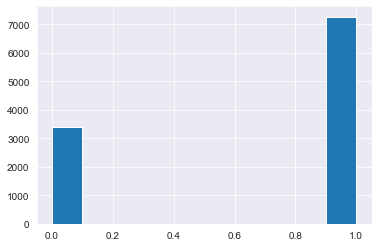

In [5]:
data["diagnosis"].hist()

<AxesSubplot:>

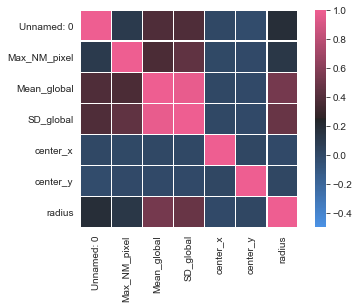

In [6]:
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

In [7]:
data = data[['Max_NM_pixel','Mean_global', 'SD_global','center_x', 'center_y', 'radius', 'diagnosis']]
data.head(10)

,Max_NM_pixel,Mean_global,SD_global,center_x,center_y,radius,diagnosis
0,0.478431,13.924183,30.215250,225.0,241.0,128.0,1.0
1,0.498039,17.189129,33.770287,256.0,213.0,183.0,1.0
2,0.670588,19.350847,36.015213,207.0,203.0,180.0,1.0
3,0.505882,17.857874,34.366390,251.0,266.0,179.0,1.0
4,0.576471,11.770942,29.151751,229.0,229.0,113.0,1.0
5,0.580392,18.548267,37.723511,219.0,256.0,153.0,1.0
6,0.509804,12.616633,29.836288,236.0,225.0,157.0,1.0
7,0.490196,10.662043,26.687437,223.0,225.0,105.0,1.0
8,0.533333,16.989056,33.859528,308.0,338.0,29.0,1.0
9,0.525490,14.061645,31.758392,219.0,222.0,116.0,1.0


<AxesSubplot:xlabel='radius', ylabel='Count'>

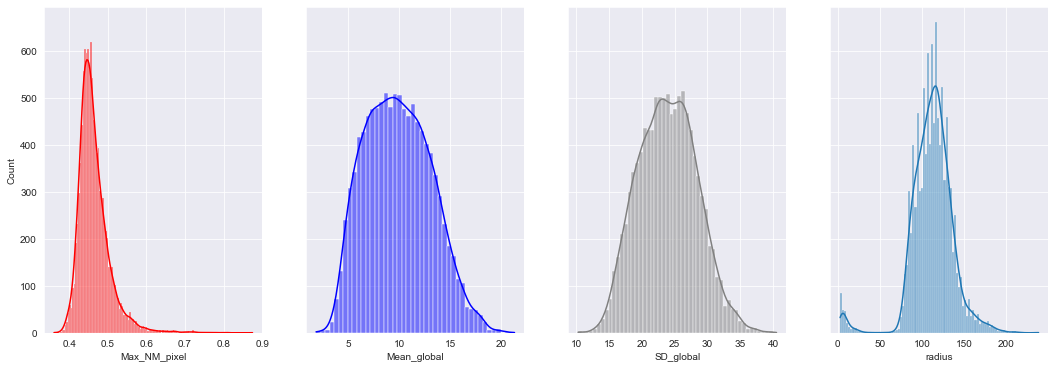

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="Max_NM_pixel", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="Mean_global", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="SD_global", kde=True, color = 'grey')
sns.histplot(data, ax=axes[3], x="radius", kde=True)

## Calculate P(Y=y) for all possible y

In [143]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

## Approach 1: Calculate P(X=x|Y=y) using Gaussian dist.

In [144]:
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [145]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Gaussian model

In [146]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[530 156]
 [450 997]]
0.7669230769230769


## Convert continuous features to Categorical features

In [147]:
data["cat_Max_NM_pixel"] = pd.cut(data["Max_NM_pixel"].values, bins = 5, labels = [0,1,2,3,4])
data["cat_Mean_global"] = pd.cut(data["Mean_global"].values, bins = 5, labels = [0,1,2,3,4])
data["cat_SD_global"] = pd.cut(data["SD_global"].values, bins = 5, labels = [0,1,2,3,4])
data["cat_Radius"] = pd.cut(data["radius"].values, bins = 5, labels = [0,1,2,3,4])

data = data.drop(columns=["Max_NM_pixel", "Mean_global", "SD_global","radius"])
data = data[["cat_Max_NM_pixel","cat_Mean_global","cat_SD_global","cat_Radius","diagnosis"]]
data.head(10)

,cat_Max_NM_pixel,cat_Mean_global,cat_SD_global,cat_Radius,diagnosis
0,1,3,3,2,1.0
1,1,3,3,3,1.0
2,3,4,4,3,1.0
3,1,4,3,3,1.0
4,2,2,3,2,1.0
5,2,4,4,3,1.0
6,1,2,3,3,1.0
7,1,2,2,2,1.0
8,1,3,3,0,1.0
9,1,3,3,2,1.0


## Approach 2: Calculate P(X=x|Y=y) categorically

In [148]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

## Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum

In [149]:
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

## Test Categorical model

In [150]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[ 455  231]
 [ 332 1115]]
0.7984246330110992
